In [0]:
import pandas as pd
import re
import os
import time
import random
import numpy as np

try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle

from nltk.translate.bleu_score import corpus_bleu

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
tf.__version__

'2.1.0-rc1'

In [0]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


### Creating a custom dataset of expressions(target) and math word problems(input)

In [0]:
## Function to convert integers to English words
def numberToWords(num):
  """
  :type num: int
  :rtype: str
  """
  def one(num):
      switcher = {
          1: 'One',
          2: 'Two',
          3: 'Three',
          4: 'Four',
          5: 'Five',
          6: 'Six',
          7: 'Seven',
          8: 'Eight',
          9: 'Nine'
      }
      return switcher.get(num)

  def two_less_20(num):
      switcher = {
          10: 'Ten',
          11: 'Eleven',
          12: 'Twelve',
          13: 'Thirteen',
          14: 'Fourteen',
          15: 'Fifteen',
          16: 'Sixteen',
          17: 'Seventeen',
          18: 'Eighteen',
          19: 'Nineteen'
      }
      return switcher.get(num)
  
  def ten(num):
      switcher = {
          2: 'Twenty',
          3: 'Thirty',
          4: 'Forty',
          5: 'Fifty',
          6: 'Sixty',
          7: 'Seventy',
          8: 'Eighty',
          9: 'Ninety'
      }
      return switcher.get(num)
  

  def two(num):
      if not num:
          return ''
      elif num < 10:
          return one(num)
      elif num < 20:
          return two_less_20(num)
      else:
          tenner = num // 10
          rest = num - tenner * 10
          return ten(tenner) + ' ' + one(rest) if rest else ten(tenner)
  
  def three(num):
      hundred = num // 100
      rest = num - hundred * 100
      if hundred and rest:
          return one(hundred) + ' Hundred ' + two(rest) 
      elif not hundred and rest: 
          return two(rest)
      elif hundred and not rest:
          return one(hundred) + ' Hundred'
  
  billion = num // 1000000000
  million = (num - billion * 1000000000) // 1000000
  thousand = (num - billion * 1000000000 - million * 1000000) // 1000
  rest = num - billion * 1000000000 - million * 1000000 - thousand * 1000
  
  if not num:
      return 'Zero'
  
  result = ''
  if billion:        
      result = three(billion) + ' Billion'
  if million:
      result += ' ' if result else ''    
      result += three(million) + ' Million'
  if thousand:
      result += ' ' if result else ''
      result += three(thousand) + ' Thousand'
  if rest:
      result += ' ' if result else ''
      result += three(rest)
  return result

In [0]:
## creating a simple dataset with random number of operations(one, two or three operations),
## random number (uptil 50000) and random operations
def create_simple_dataset(dataset_len = 1000):
  ops_dict = {'+':['plus','add'],'-':['minus','subtract'],'*':['multiply','into'],'/':['divide','by']}


  nums_dict = {}
  
  for i in range(50000):
    nums_dict[i] = numberToWords(i)
  

  num_ops = [2,3,4]
  nums_dict_keys_list = list(nums_dict.keys())
  ops_dict_keys_list = list(ops_dict.keys())

  all_input_exps = []
  all_target_exps = []
  for _ in range(dataset_len):
    n_o = random.choice(num_ops)
    
    nums = []
    num_vals = []
    for i in range(n_o+1):
      nums.append(random.choice(nums_dict_keys_list))
      num_vals.append(nums_dict[nums[i]])

    ops = []
    ops_vals = []
    for i in range(n_o):
      ops.append(random.choice(ops_dict_keys_list))
      ops_vals.append(random.choice(ops_dict[ops[i]]))

    target_exp = ' '.join(list(str(nums[0])))
    inp_exp = num_vals[0]
    for i in range(n_o):
      target_exp = target_exp + ' ' + ops[i] + ' ' + ' '.join(list(str(nums[i+1])))
      inp_exp = inp_exp + ' ' + ops_vals[i] + ' ' + num_vals[i+1]

    all_input_exps.append(inp_exp)
    all_target_exps.append(target_exp)

  return all_input_exps,all_target_exps

In [0]:
input_exps, target_exps = create_simple_dataset(2000000)

In [0]:
input_exps[:5]

['Thirty Five Thousand Six Hundred Twenty divide Forty Eight Thousand Nine Hundred Eight minus Forty Nine Thousand Two Hundred Nineteen plus Forty Eight Thousand Seven Hundred Thirty Four',
 'Forty Eight Thousand Nine Hundred Fifty Six into Sixteen Thousand Seven Hundred Thirty Four minus Thirteen Thousand Ninety One add Twenty Nine Thousand One Hundred Five multiply Thirty Thousand One Hundred Thirty Three',
 'Twenty Six Thousand Two Hundred Twenty One into Forty Six Thousand Three Hundred Fifty Five by Thirty Four Thousand Seven Hundred Forty Eight add Thirteen Thousand Eighty One add Three Thousand Three Hundred Ninety Two',
 'Twenty Eight Thousand Four Hundred Fifty Five by Twenty Thousand Four Hundred Nine subtract Nine Thousand Eight Hundred Forty Five minus Thirty Nine Thousand Two Hundred Sixty Seven',
 'Forty Three Thousand Five Hundred Eighty subtract Forty Six Thousand Two Hundred Fifty Nine divide Two Thousand Five Hundred Sixty Four']

In [0]:
target_exps[:5]

['3 5 6 2 0 / 4 8 9 0 8 - 4 9 2 1 9 + 4 8 7 3 4',
 '4 8 9 5 6 * 1 6 7 3 4 - 1 3 0 9 1 + 2 9 1 0 5 * 3 0 1 3 3',
 '2 6 2 2 1 * 4 6 3 5 5 / 3 4 7 4 8 + 1 3 0 8 1 + 3 3 9 2',
 '2 8 4 5 5 / 2 0 4 0 9 - 9 8 4 5 - 3 9 2 6 7',
 '4 3 5 8 0 - 4 6 2 5 9 / 2 5 6 4']

In [0]:
len(pd.Series(target_exps)), len(pd.Series(target_exps).unique())

(2000000, 2000000)

In [0]:
data = pd.DataFrame({'Input':input_exps, 'Target':target_exps})

In [0]:
data.to_pickle('data-baseline.pkl')

### Preprocessing and Tokenizing the Input and Target exps

In [0]:
with open('data-baseline.pkl', 'rb') as f:
  data = pickle.load(f)

In [0]:
input_exps = list(data.Input.values)
target_exps = list(data.Target.values)

In [0]:
input_exps[0], target_exps[0]

('Thirty Five Thousand Six Hundred Twenty divide Forty Eight Thousand Nine Hundred Eight minus Forty Nine Thousand Two Hundred Nineteen plus Forty Eight Thousand Seven Hundred Thirty Four',
 '3 5 6 2 0 / 4 8 9 0 8 - 4 9 2 1 9 + 4 8 7 3 4')

In [0]:
## right now, only adding start and end token
## Can later preprocess more: add spaces before and after punctuations, replace unimp tokens, etc.
def preprocess_strings(sentence):
  sentence = sentence.lower().strip()
  return '<start> ' + sentence + ' <end>'

In [0]:
preprocessed_input_exps = list(map(preprocess_strings, input_exps))
preprocessed_target_exps = list(map(preprocess_strings, target_exps))

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [0]:
input_tensor, inp_lang_tokenizer = tokenize(preprocessed_input_exps)

In [0]:
len(inp_lang_tokenizer.word_index)

40

In [0]:
input_tensor

array([[15,  5,  7, ...,  0,  0,  0],
       [15,  3,  9, ...,  0,  0,  0],
       [15,  4, 12, ...,  0,  0,  0],
       ...,
       [15, 32,  1, ...,  0,  0,  0],
       [15,  4,  8, ...,  0,  0,  0],
       [15, 13,  1, ...,  0,  0,  0]], dtype=int32)

In [0]:
target_tensor, targ_lang_tokenizer = tokenize(preprocessed_target_exps)

In [0]:
len(targ_lang_tokenizer.word_index)

16

In [0]:
target_tensor

array([[11,  3,  9, ...,  0,  0,  0],
       [11,  1,  7, ...,  3,  3, 12],
       [11,  2,  8, ...,  2, 12,  0],
       ...,
       [11,  4,  7, ...,  0,  0,  0],
       [11,  2,  1, ...,  0,  0,  0],
       [11,  6,  5, ...,  0,  0,  0]], dtype=int32)

### Create a tf.data dataset

In [0]:
# Creating training and validation sets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.01, random_state=42)

In [0]:
len(input_tensor_train)

1980000

In [0]:
len(input_tensor_val)

20000

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 512
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 64
units = 256
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
vocab_inp_size, vocab_tar_size

(41, 17)

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([512, 41]), TensorShape([512, 31]))

### Encoder Decoder Model

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (512, 41, 256)
Encoder Hidden state shape: (batch size, units) (512, 256)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(100)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (512, 256)
Attention weights shape: (batch_size, sequence_length, 1) (512, 41, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (512, 17)


In [0]:
sample_hidden.shape

TensorShape([512, 256])

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoints

In [0]:
# !rm -r /gdrive/My\ Drive/checkpoints/ADL\ Project/training_checkpoints/aashna_baseline

In [0]:
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "ADL Project/training_checkpoints/aashna_baseline")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Checkpoints directory is /gdrive/My Drive/checkpoints/ADL Project/training_checkpoints/aashna_baseline
Checkpoints folder already exists


In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [0]:
latest

In [0]:
if latest:
  epoch_num = int(latest.split('/')[-1].split('-')[-1])
  checkpoint.restore(latest)
else:
  epoch_num = 0

In [0]:
epoch_num

0

### Training

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 5

for epoch in range(epoch_num, EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  checkpoint.save(file_prefix = checkpoint_prefix)
  print('Saved epoch: {}'.format(epoch+1))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1338
Epoch 1 Batch 100 Loss 1.8552
Epoch 1 Batch 200 Loss 1.6436
Epoch 1 Batch 300 Loss 1.6049
Epoch 1 Batch 400 Loss 1.6153
Epoch 1 Batch 500 Loss 1.5431
Epoch 1 Batch 600 Loss 1.5223
Epoch 1 Batch 700 Loss 1.5490
Epoch 1 Batch 800 Loss 1.5062
Epoch 1 Batch 900 Loss 1.4740
Epoch 1 Batch 1000 Loss 1.4543
Epoch 1 Batch 1100 Loss 1.3986
Epoch 1 Batch 1200 Loss 1.3051
Epoch 1 Batch 1300 Loss 1.0260
Epoch 1 Batch 1400 Loss 0.9643
Epoch 1 Batch 1500 Loss 1.0915
Epoch 1 Batch 1600 Loss 0.4079
Epoch 1 Batch 1700 Loss 0.2810
Epoch 1 Batch 1800 Loss 0.2225
Epoch 1 Batch 1900 Loss 0.1507
Epoch 1 Batch 2000 Loss 0.0709
Epoch 1 Batch 2100 Loss 1.1790
Epoch 1 Batch 2200 Loss 0.4887
Epoch 1 Batch 2300 Loss 1.8735
Epoch 1 Batch 2400 Loss 1.4612
Epoch 1 Batch 2500 Loss 1.4240
Epoch 1 Batch 2600 Loss 1.4220
Epoch 1 Batch 2700 Loss 1.3512
Epoch 1 Batch 2800 Loss 1.3432
Epoch 1 Batch 2900 Loss 1.3149
Epoch 1 Batch 3000 Loss 1.2295
Epoch 1 Batch 3100 Loss 1.3098
Epoch 1 Batch 3200 L

### Evaluation

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_strings(sentence)

    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
def evaluate_accuracy(inputs):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in range(len(inputs.numpy()[0])):
      if inputs.numpy()[0][i] != 0:
        sentence += inp_lang_tokenizer.index_word[inputs.numpy()[0][i]] + ' '

    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    result_seq = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result_seq += str(predicted_id) +' '
        
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result_seq, result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result_seq, result, sentence, attention_plot

In [0]:
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(1, drop_remainder=True)

In [0]:
y_true = []
y_pred = []
acc_cnt = 0

a = 0
for (inp_val_batch, target_val_batch) in iter(dataset_val):
  a += 1
  if a % 500 == 0:
    print(a)
    print("Accuracy count: ",acc_cnt)
    print('------------------')
  target_sentence = ''
  for i in target_val_batch.numpy()[0]:
    if i!= 0:
      target_sentence += (targ_lang_tokenizer.index_word[i] + ' ')
  target_sentence = target_sentence.split('<start> ')[1]
  
  y_true.append([target_sentence.split(' ')])

  res_seq, res, sent, att = evaluate_accuracy(inp_val_batch)
  y_pred.append(res.split(' '))
  
  if target_sentence == res:
    acc_cnt += 1

500
Accuracy count:  481
------------------
1000
Accuracy count:  967
------------------
1500
Accuracy count:  1454
------------------
2000
Accuracy count:  1935
------------------
2500
Accuracy count:  2411
------------------
3000
Accuracy count:  2901
------------------
3500
Accuracy count:  3376
------------------
4000
Accuracy count:  3858
------------------
4500
Accuracy count:  4345
------------------
5000
Accuracy count:  4829
------------------
5500
Accuracy count:  5310
------------------
6000
Accuracy count:  5789
------------------
6500
Accuracy count:  6268
------------------
7000
Accuracy count:  6753
------------------
7500
Accuracy count:  7234
------------------
8000
Accuracy count:  7720
------------------
8500
Accuracy count:  8202
------------------
9000
Accuracy count:  8684
------------------
9500
Accuracy count:  9161
------------------
10000
Accuracy count:  9641
------------------
10500
Accuracy count:  10120
------------------
11000
Accuracy count:  10602
-----

In [0]:
print('Corpus BLEU score of the model: ', corpus_bleu(y_true, y_pred))

Corpus BLEU score of the model:  0.9951898934618143


In [0]:
print('Accuracy of the model: ',acc_cnt/len(input_tensor_val))

Accuracy of the model:  0.9656


#### Translation and Attention Plots

In [0]:
check_str = 'One Thousand Three Hundred Nine subtract Fourteen Thousand Three Hundred Nine'
check_str in input_exps

False

Input: <start> one thousand three hundred nine subtract fourteen thousand three hundred nine <end>
Predicted translation: 1 3 0 9 - 1 4 3 0 9 <end> 


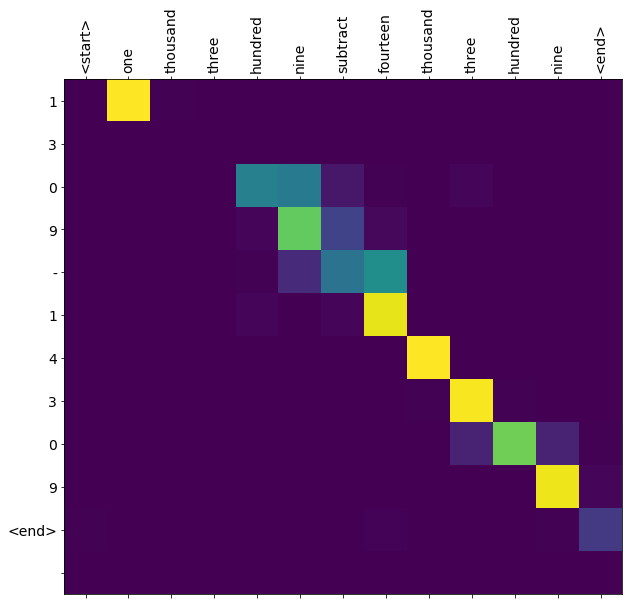

In [0]:
translate(check_str)

Input: <start> thirty plus one hundred twenty five <end>
Predicted translation: 3 0 0 5 5 <end> 


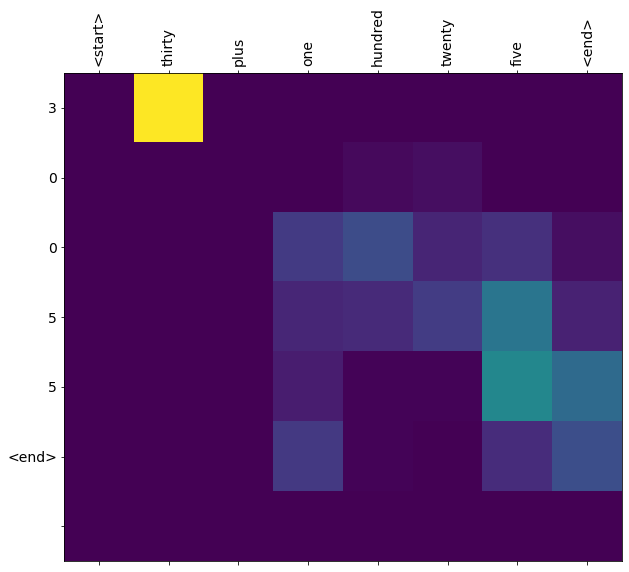

In [0]:
translate("thirty plus one hundred twenty five")

Input: <start> one plus two <end>
Predicted translation: 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


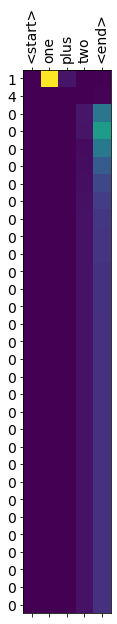

In [0]:
translate('One plus Two')

### Conclusions

We can see that this baseline model on this simple dataset is clearly memorizing the data rather than learning the actual way to translate the words to an equation.
The Corpus BLEU and Accuracy scores are very high, but the translation fails on simple equations like "One plus Two"

Sources:
1. https://www.tensorflow.org/tutorials/text/nmt_with_attention#top_of_page